Start a new notebook and attach it to your repo

In [1]:
# 1. Go to /content
%cd /content

# 2. Clone your repo (skip if already cloned)
!git clone https://github.com/Melaniemweru/NLP-warning-system.git

# 3. Enter the repo
%cd NLP-warning-system

# 4. See structure
!ls


/content
Cloning into 'NLP-warning-system'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 120 (delta 52), reused 61 (delta 18), pack-reused 0 (from 0)
Receiving objects: 100% (120/120), 510.02 KiB | 2.59 MiB/s, done.
Resolving deltas: 100% (52/52), done.
/content/NLP-warning-system
app.py	data  docs  notebooks  README.md  requirements.txt  src


In [2]:
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"
os.environ["WANDB_SILENT"] = "true"


Load Processed Splits

In [3]:
import os
import pandas as pd

assert os.path.exists("data/processed/X_train.csv"), "Missing split files."

X_train = pd.read_csv("data/processed/X_train.csv")
X_val   = pd.read_csv("data/processed/X_val.csv")
X_test  = pd.read_csv("data/processed/X_test.csv")

y_train = pd.read_csv("data/processed/y_train.csv").squeeze()
y_val   = pd.read_csv("data/processed/y_val.csv").squeeze()
y_test  = pd.read_csv("data/processed/y_test.csv").squeeze()

print("Train:", X_train.shape, " | y:", y_train.shape)
print("Val:", X_val.shape, " | y:", y_val.shape)
print("Test:", X_test.shape, " | y:", y_test.shape)

print("\nTrain label counts:")
print(y_train.value_counts())


Train: (3500, 8)  | y: (3500,)
Val: (750, 8)  | y: (750,)
Test: (750, 8)  | y: (750,)

Train label counts:
label
Compliant        2250
Non-Compliant    1250
Name: count, dtype: int64


Prepare HF Datasets

In [4]:
# Convert labels to integers
label2id = {"Compliant": 0, "Non-Compliant": 1}

train_df = pd.DataFrame({
    "text": X_train["narrative"],
    "labels": y_train.map(label2id).astype(int)
})

val_df = pd.DataFrame({
    "text": X_val["narrative"],
    "labels": y_val.map(label2id).astype(int)
})

test_df = pd.DataFrame({
    "text": X_test["narrative"],
    "labels": y_test.map(label2id).astype(int)
})

print(train_df.head())


                                                text  labels
0  verified. ID patterns; historical with aligned...       0
1  Transaction for salary processed at Nairobi; I...       0
2  reviewed. statements Nairobi; at processed rep...       0
3  Processed salary or bill payment at Thika; ID ...       0
4  checked. invoice Thika; at repayment loan for ...       0


Convert pandas to Hugging Face Datasets

In [5]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(val_df),
    "test": Dataset.from_pandas(test_df)
})

dataset


DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 3500
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 750
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 750
    })
})

Load FinBERT

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_NAME = "yiyanghkust/finbert-tone"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    id2label={0:"Compliant", 1:"Non-Compliant"},
    label2id={"Compliant":0, "Non-Compliant":1},
    ignore_mismatched_sizes=True
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-tone and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TOKENIZATION

In [7]:
def tokenize_function(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"]
)

tokenized_dataset.set_format("torch")


Map:   0%|          | 0/3500 [00:00<?, ? examples/s]

Map:   0%|          | 0/750 [00:00<?, ? examples/s]

Map:   0%|          | 0/750 [00:00<?, ? examples/s]

Training Arguments

In [8]:
from transformers import TrainingArguments

batch_size = 8

training_args = TrainingArguments(
    output_dir="finbert_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)


⚙️  Running in WANDB offline mode


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Metrics

In [9]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary"
    )
    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


Train

In [10]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()


/tmp/ipython-input-351656968.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.012800,0.000046,1.000000,1.000000,1.000000,1.000000
2,0.000000,0.000020,1.000000,1.000000,1.000000,1.000000
3,0.000000,0.000016,1.000000,1.000000,1.000000,1.000000


TrainOutput(global_step=1314, training_loss=0.004309028139000523, metrics={'train_runtime': 322.744, 'train_samples_per_second': 32.534, 'train_steps_per_second': 4.071, 'total_flos': 690666520320000.0, 'train_loss': 0.004309028139000523, 'epoch': 3.0})

In [11]:
import wandb
wandb.init(mode="disabled")


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


Evaluate on test set

In [12]:
test_results = trainer.evaluate(tokenized_dataset["test"])
test_results
print(f"Model Accuracy: {test_results['eval_accuracy']*100:.2f}%")


Model Accuracy: 100.00%


Save Model + Tokenizer

In [13]:
save_path = "src/models/finbert"
os.makedirs(save_path, exist_ok=True)

model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print("Saved to:", save_path)


Saved to: src/models/finbert


Confusion matrix

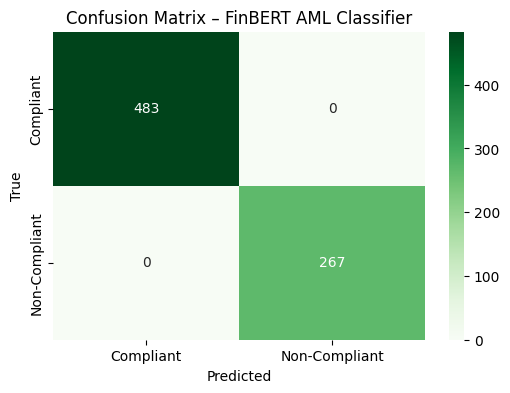

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get predictions from FinBERT
preds = trainer.predict(tokenized_dataset["test"])
logits = preds.predictions
y_test_pred = np.argmax(logits, axis=1)

# Convert y_test text labels → integers
y_test_int = y_test.map({"Compliant":0, "Non-Compliant":1}).to_numpy()

cm = confusion_matrix(y_test_int, y_test_pred, labels=[0,1])

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Compliant", "Non-Compliant"],
            yticklabels=["Compliant", "Non-Compliant"])
plt.title("Confusion Matrix – FinBERT AML Classifier")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
